# Parser results -- Maltparser, default settings (1.2 updated)

This notebook will perform the same experiments as [the previous one](/notebooks/4.%20Analysis%20of%20parser%20results%20%28Mate%20tools%29.ipynb) for Mate tools, only instead using Maltparser run with default settings. We are also testing the entire UD 1.2 collection, instead of just looking at 1.0 as for Mate.

## Preprocessing

The conllu files had to be preprocessed to support the conllx format. This was done using the `tools/conllu2conllx.py` script. Thereafter the models were trained and tested with `tools/train_maltparser_default.py` and `tools/test_maltparser_default.py`.

#### Functional and content dependents
As specified in [A manual classification of dependency relations](/notebooks/3.%20A%20manual%20classification%20of%20dependency%20relations.ipynb)

- Functional dependents
- Content dependendents

#### Dependent classes as specified in the [UD documentation](http://universaldependencies.github.io/docs/u/dep/index.html)

- Classes expected to perform better than overall LAS for __synthetic__ languages:
  - __Core dependents of clausal predicates__: nsubj, csubj, nsubjpass, csubjpass, dobj, ccomp, xcomp, iobj
  - __Non-core dependents of clausal predicates__: nmod, advcl, advmod, neg
  - __Noun dependents, excluding _det_ and _neg___: nummod, acl, amod, appos, nmod
  - __Coordination, excluding _cc_ and _punct___: conj
  - 
- Classes expected to perform better than overall LAS for __isolated__ languages:
  - __Special clausal dependents__: vocative, aux, mark, discourse, auxpass, punct, expl, cop
  - __Case-marking, prepositions, possessive__: case


## Things to keep in mind when looking at the results

- Irish and Hungarian has fairly little data, and can't probably be trusted. 
- Czech has A LOT of data.

In [28]:
# Matplotlib
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
mpl.style.use('ggplot')
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pgf', FigureCanvasPgf)

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys, os
sys.path.append("../tools/")
from collections import defaultdict

# Data management libraries
import pandas as pd
#import seaborn as sns

# Treebank utils, found in "../tools"
import udeval, lang_utils, dependency_classes

is_labeled = True
is_fine_grained_deprels = False
file_format = "conllx"
test_type = "test"

system_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/maltdefault_coarse_output_test_1-2/"
gold_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-2/universal-dependencies-1.2/"
file_prefix = "maltdefault"

system_files = lang_utils.get_system_output_paths(system_output_base, type_=test_type, format_=file_format)
gold_files = lang_utils.get_ud_paths(gold_output_base, type_=test_type, format_=file_format, coarse=not is_fine_grained_deprels)

def labeled_attachment_scores():
    las = {}
    for lang, system_path in system_files.items():
        s_out = system_path
        g_out = gold_files[lang]
        score = udeval.attachment_score(s_out, g_out, labeled=is_labeled, fine_grained_deprels=is_fine_grained_deprels)
        las[lang] = score
    return pd.Series(las)

def averaged_weighted_attachment_scores():
    wlas = {}
    wde = pd.Series.from_csv('../data/function_content_degree.wde.csv').to_dict()
    wde['punct'] = 0
    for lang, system_path in system_files.items():
        s_out = system_path
        g_out = gold_files[lang]
        score = udeval.weighted_las(s_out, g_out, wde)
        wlas[lang] = score
    return pd.Series(wlas)

def individual_weighted_attachment_scores():
    wdes = pd.DataFrame.from_csv('../data/function_content_degree.individual_languages.wde.csv')
    for lang, system_path in system_files.items():
        wdes[lang]['punct'] = 0
        s_out = system_path
        g_out = gold_files[lang]
        score = udeval.weighted_las(s_out, g_out, wdes[lang].to_dict())
        wlas[lang] = score
    return pd.Series(wlas)

def precision_recall_filter_labels(labels):
    prec_recs = {"precision": [], "recall": []}
    index = []
    for lang, system_path in system_files.items():
        s_out = system_path
        g_out = gold_files[lang]
        precision, recall = udeval.labels_precision_recall(s_out, 
                                                           g_out, 
                                                           labels=labels,
                                                           fine_grained_deprels=is_fine_grained_deprels)
        index.append(lang)
        prec_recs["precision"].append(precision)
        prec_recs["recall"].append(recall)

    return pd.DataFrame(prec_recs, index=index).sort_values("precision")

In [29]:
individual_wlas = individual_weighted_attachment_scores()
individual_wlas.to_csv('../data/' + file_prefix + '.individual_wlas.csv')

NameError: name 'wlas' is not defined

In [39]:
averaged_wlas = averaged_weighted_attachment_scores()
averaged_wlas.to_csv('../data/' + file_prefix + '.averaged_wlas.csv')

In [40]:
las = labeled_attachment_scores()
las.to_csv('../data/' + file_prefix + '.las.csv')

# Performance for dependency classes

We calculate the precision and recall only using the labels classified as content relations. We then subtract the LAS to present how large of an increase (or reduction) in results the label class gets.

### Content and function relations

#### Absolute performance

In [37]:
content_dependents_result = precision_recall_filter_labels(dependency_classes.content_dependents)
function_dependents_result = precision_recall_filter_labels(dependency_classes.function_dependents)
results_dict = {"Content": content_dependents_result, 
                "Function": function_dependents_result}

content_function_results = pd.concat(results_dict.values(), keys=results_dict.keys(), axis=1)

In [41]:
content_function_results.to_csv('../data/' + file_prefix + '.content_function.precision_recall.csv')
lang_measures = pd.concat([averaged_wlas,
                           las, 
                           content_function_results], 
                          axis=1).rename(columns={0: 'WLAS', 
                                                  1: 'LAS', 
                                                  ('Content', 'precision'): 'C prec', 
                                                  ('Function', 'precision'): 'F prec', 
                                                  ('Content', 'recall'): 'C rec', 
                                                  ('Function', 'recall'): 'F rec'})
lang_measures.to_csv('../data/maltdefault.lang_measures.csv')

## Individual dependency performance

In [170]:
label_performance = {}
for label in dependency_classes.all_labels:
    label_performance[label] = precision_recall_filter_labels({label})

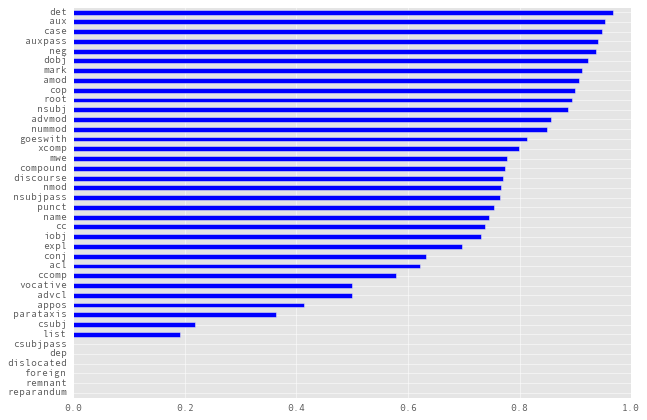

In [189]:
english_recall = pd.Series({x:y.loc['English']['recall'] for x,y in label_performance.items()}).fillna(0)
english_recall.sort_values().plot(kind='barh')

## Function correct given head

In [35]:
import udtree
def right_wrong(system_tree, gold_tree, labeled=False, fine_grained_deprels=False, ignore_deprels=None):
    if ignore_deprels:
        ignore_deprels = set(ignore_deprels)
    correct = []
    total = 0
    for (index,
         system_head,
         system_label,
         gold_head,
         gold_label) in zip(gold_tree.ids,
                            system_tree.heads,
                            system_tree.deprels,
                            gold_tree.heads,
                            gold_tree.deprels):

        if not fine_grained_deprels:
            gold_label = gold_label.split(":")[0]
            system_label = system_label.split(":")[0]

        is_correct = False
        if system_head == gold_head:
            is_correct = True
            if labeled and system_label != gold_label:
                is_correct = False

        if is_correct:
            correct.append((True, gold_label, system_head))
        else:
            correct.append((False, gold_label, system_head))

    return correct

def function_correct_head(system_output_path, gold_path, labels, labeled):
    system = udtree.from_files(system_output_path)
    gold = udtree.from_files(gold_path)
    correct_head, incorrect_head = 0, 0
    for system_tree, gold_tree in zip(system, gold):
        res= right_wrong(system_tree, gold_tree, labeled,
                         fine_grained_deprels=False)

        for correct, gold_label, system_head in res:
            if not correct and gold_label in labels:
                head_index = system_head-1
                if head_index >= 0 and res[head_index][0]:
                    correct_head += 1
                else:
                    incorrect_head += 1

    return correct_head / (incorrect_head + correct_head)

In [36]:
lang_res = {}
for lang, system_path in system_files.items():
    s_out = system_path
    g_out = gold_files[lang]
    lang_res[lang] = {}
    lang_res[lang]['Function labeled'] = function_correct_head(s_out, g_out, dependency_classes.function_dependents, labeled=True)
    lang_res[lang]['Content labeled'] = function_correct_head(s_out, g_out, dependency_classes.content_dependents, labeled=True)
    lang_res[lang]['Function unlabeled'] = function_correct_head(s_out, g_out, dependency_classes.function_dependents, labeled=False)
    lang_res[lang]['Content unlabeled'] = function_correct_head(s_out, g_out, dependency_classes.content_dependents, labeled=False)

res = pd.DataFrame(lang_res).transpose()
res.to_csv('../data/maltdefault.cascading_errors.csv')
res

,Content labeled,Content unlabeled,Function labeled,Function unlabeled
Arabic,0.513789,0.563860,0.398017,0.489478
Bulgarian,0.552858,0.548533,0.506596,0.559701
Croatian,0.474149,0.459615,0.318436,0.267606
Czech,0.486107,0.457754,0.371002,0.354005
Danish,0.407881,0.401361,0.233010,0.246154
English,0.477665,0.438391,0.329310,0.363806
Finnish,0.391100,0.376749,0.246106,0.289116
Gothic,0.369090,0.325050,0.311284,0.368421
Greek,0.443193,0.433289,0.308550,0.333333
Hebrew,0.508979,0.543077,0.332308,0.466216


This means that function dependency errors are MORE likely to come from cascading errors than content dependency errors. For Finnish, only 20% of the function errors have correct head, while English and Hindi have up to 30%. There doesn't seem to be any correlation happening here.

For faulty content dependencies, a higher ratio have correct heads. What does this mean?

This means that function dependencies are more likely to be due to cascading errors. 